In [1]:
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy import signal
from timeit import default_timer as timer
import csv

from astropy import units as u
from astropy.coordinates import Angle
from scipy.interpolate import RectBivariateSpline


import phase_corr_make_universe_3D as uni
import cross_spec_3D
import pspec_3D

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'


%load_ext autoreload
%autoreload 2

# 2) Creating $\sigma(k)$ functions for each $z$ bin

### a) Extract $r(k)$ from Gong et al. 

In [2]:
r6 = open('r_z6.csv')
r7 = open('r_z7.csv')
r8 = open('r_z8.csv')

csv6 = csv.reader(r6)
csv7 = csv.reader(r7)
csv8 = csv.reader(r8)

rows6 = []
for row in csv6:
        rows6.append(row)
        
r_6 = np.zeros((len(rows6),2))

for i in range(len(rows6)):
    for j in range(len(rows6[1])):
        r_6[i,j] = float(rows6[i][j])
        
rows7 = []
for row in csv7:
        rows7.append(row)
        
r_7 = np.zeros((len(rows7),2))

for i in range(len(rows7)):
    for j in range(len(rows7[1])):
        r_7[i,j] = float(rows7[i][j])
        
rows8 = []
for row in csv8:
        rows8.append(row)
        
r_8 = np.zeros((len(rows8),2))

for i in range(len(rows8)):
    for j in range(len(rows8[1])):
        r_8[i,j] = float(rows8[i][j])
    

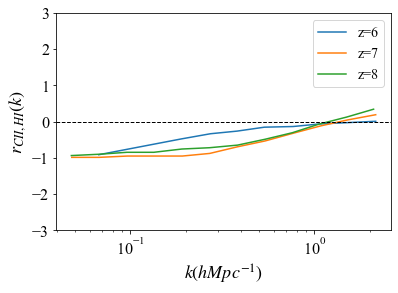

In [3]:
plt.semilogx(r_6[:,0],r_6[:,1],label = 'z=6')
plt.semilogx(r_7[:,0],r_7[0:,1], label = 'z=7')
plt.semilogx(r_8[:,0],r_8[0:,1], label = 'z=8')
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.ylim(-3,3)
plt.xlabel('$k (h Mpc^{-1}$)', fontsize= 18)
plt.ylabel('$r_{CII,HI}(k)$', fontsize= 18)
plt.legend(fontsize= 14)

### b) Interpolate to get multivariate $r(k,z)$

need to reject the lowest k mode because it doesn't have a counterpart at z = 6

In [4]:
r_full = np.reshape((np.concatenate((r_6[:,1],r_7[1:,1],r_8[1:,1]),axis = 0)),(3,11))
k = r_8[1:,0]
z = np.arange(6,9,1)

r_func = interpolate.interp2d(k,z,r_full)

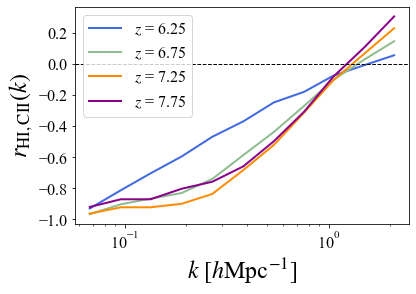

In [45]:
z_test = [6.25,6.75,7.25,7.75]#np.linspace(6,8,11)
# z_test = [6,7,8,9]#np.linspace(6,8,11)

colors  = ['royalblue' ,'darkseagreen','darkorange','darkmagenta']

for i in range(len(z_test)):
    plt.semilogx(k,r_func(k,z_test[i]), label = r'$z$ = %s' %z_test[i],color = colors[i],linewidth = 2)
plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)


### c) Get $\sigma(k,z)$ from $r(k,z)$

\begin{align}
r(k) &= \frac{P_x(k)}{\sqrt{P_1(k)P_2(k)}} \\
     &= \frac{P_x(k)}{\sqrt{P_1(k)P_1(k)}}\\
     &= \frac{P_x(k)}{P_1(k)} = sgn(r(k)) e^{-\sigma(k)^2/2}\\
\end{align}

\begin{equation}
\sigma(k) = \sqrt{\ln(|r(k)|^{-2})}
\end{equation}

review the sign thingy, I think the way I implement it is right but reminder to recheck that 

In [46]:
def sigma(k,z):
    littleh = cosmo.H0.value/100
    k_h = k/littleh
    return np.sqrt(np.log(np.abs(r_func(k_h,z))**(-2)))

def sign_sigma(k,z):
    littleh = cosmo.H0.value/100
    k_h = k/littleh
    sign = float(np.sign(r_func(k_h,z)))
    return sign


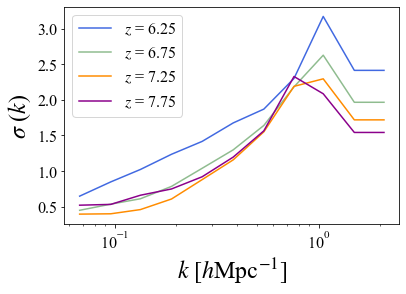

In [47]:
for i in range(len(z_test)):
    plt.semilogx(k,sigma(k,z_test[i]), label = '$z$ = %s' %z_test[i], color = colors[i])
# plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$\sigma$ ($k$)', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
# plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)


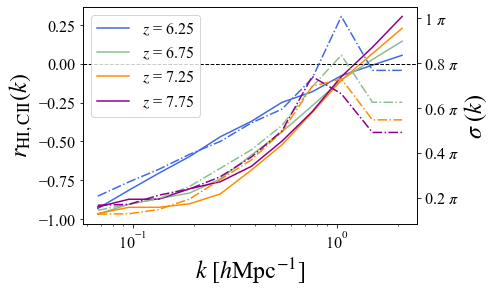

In [67]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

for i in range(len(z_test)):
    ax1.semilogx(k,r_func(k,z_test[i]), label = r'$z$ = %s' %z_test[i],color = colors[i],)
    
    ax2.semilogx(k,sigma(k,z_test[i])/np.pi, label = '$z$ = %s' %z_test[i], color = colors[i], linestyle = '-.')

ax2.locator_params(axis='y', nbins=7)
ax2.set_ylabel(r'$\sigma$ ($k$)', fontsize = 24)
ax1.set_ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
ax1.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)


ax2.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax2.yaxis.set_major_locator(tck.MultipleLocator(base=0.2))
ax1.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax1.legend(fontsize = 16)
plt.show()

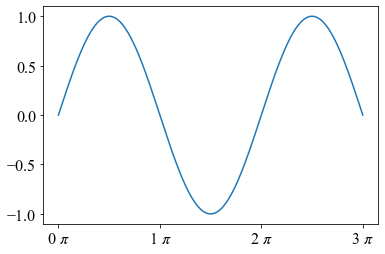

In [42]:
import matplotlib.ticker as tck
f,ax=plt.subplots(1)
x=np.linspace(0,3*np.pi,1001)
y=np.sin(x)
ax.plot(x/np.pi,y)
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=1.0))

# 3) Generate 21 cm and [CII] fields (CHECKPOINT)

### a) Generate fields using the correlation and sign functions defined above

In [29]:
npix_row,npix_col, npix_aisle =50,200,200
freq_mid = 1420/(1+8)
pm_freq = 19.127/2

freqs = np.linspace(freq_mid-pm_freq, freq_mid+pm_freq,npix_aisle)

Lx = 325.5
theta_x = Lx/(cosmo.comoving_distance(8).value)

Ly = 325.5
theta_y = Ly/(cosmo.comoving_distance(8).value)

Lz = 325.49848672680474
nu = Lz/(((sc.c*((1+8)**2))/(cosmo.H0.value*1000*(1.24e9)*cosmo.efunc(8))))

nbins = 30



In [30]:
def ps(x):
    return x**(-2)

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_60834/2590249288.py:2: RuntimeWarning: divide by zero encountered in power
  return x**(-2)


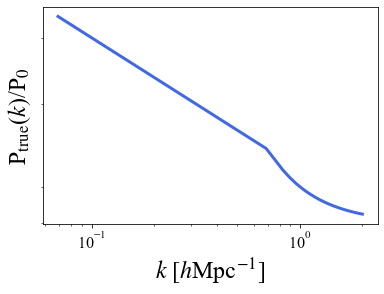

In [31]:
x = np.linspace(0,2,30)
plt.semilogx(x,ps(x) , color = 'royalblue', linewidth = 3)
plt.locator_params(axis='y', nbins=1)
plt.ylabel(r'P$_\mathrm{true}$($k$)/P$_0$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.yscale('symlog')

# plt.plot([0, 10], [0, 10])
# plt.xlabel("X Label")
# plt.ylabel("Y Label")


ax = plt.gca()
# ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

# plt.grid(True)
plt.show()

In [32]:
uni_3d = uni.universe(ps,npix_row,npix_col,npix_aisle, Ly,Lx,Lz,nbins,sigma,sign_sigma,z_mid = 8)
uni_3d.make_universe()

325.5 325.5 325.49848672680474


Text(0.5, 1.01, '[CII] Field')

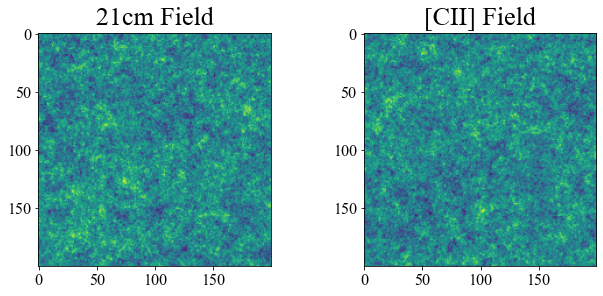

In [35]:
fig = plt.figure(figsize = (10,20),constrained_layout=False)
gs = fig.add_gridspec(1, 2,hspace =0.2, wspace= 0.4)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(uni_3d.universe[1])
ax1.set_title('21cm Field', fontsize = 26, y = 1.01)

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(uni_3d.universe_decorr[1])
ax2.set_title('[CII] Field', fontsize = 26, y= 1.01)




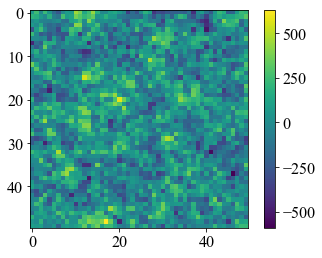

In [13]:
plt.imshow(uni_3d.universe_decorr[:,:,1]*1000)
plt.colorbar()

### Compute cross and auto spectra and compare with theory 

\begin{equation}
    P_{x,theory} = r_{theory}(k) \times P_{1,theory}(k)
\end{equation}

In [18]:
cross_spec = cross_spec_3D.Power_Spectrum(uni_3d.universe,uni_3d.universe_decorr, theta_x, theta_y,freqs*(1e6),1420*(1e6),30, 60)
cross_spec.compute_1d_from_2d()

pspec = pspec_3D.Power_Spectrum(uni_3d.universe, theta_x, theta_y,freqs*(1e6),1420*(1e6),30, 60)
pspec.compute_1d_from_2d()


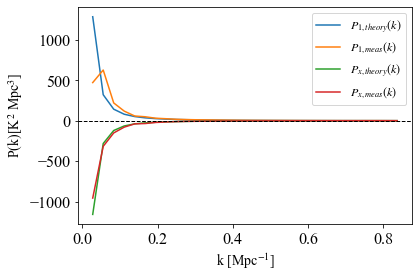

In [24]:
plt.plot(pspec.k_modes,ps(pspec.k_modes),label = '$P_{1,theory}(k)$')
plt.plot(pspec.k_modes,pspec.pspec_1D,label = '$P_{1,meas}(k)$')
plt.plot(pspec.k_modes,r_func(pspec.k_modes/(cosmo.H0.value/100),8)*ps(pspec.k_modes), label = '$ P_{x,theory}(k)$')
plt.plot(cross_spec.k_modes[1:], cross_spec.pspec_1D, label = "$P_{x,meas}(k)$")
plt.ylabel('P(k)[K$^2$ Mpc$^3$]', fontsize = 14)
plt.xlabel('k [Mpc$^{-1}$]', fontsize = 14)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)

plt.legend(fontsize = 12)

### c) Compare original $r(k)$ with the one you recover given the cross spectrum measurement 

\begin{equation}
r_{meas}(k) = \frac{P_{x,meas}(k)}{P_{1,meas}(k)}
\end{equation}

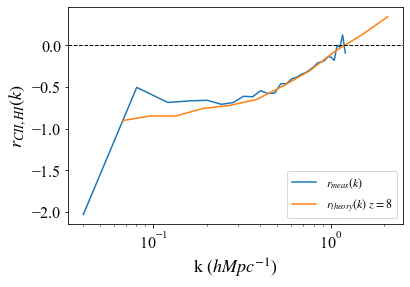

In [25]:
plt.semilogx(pspec.k_modes/(cosmo.H0.value/100),cross_spec.pspec_1D/pspec.pspec_1D, label = '$r_{meas}(k)$')
plt.semilogx(k,r_func(k,8), label = '$r_{theory}(k)$ $z = 8$' )
plt.xlabel('k ($h Mpc^{-1}$)', fontsize= 18)
plt.ylabel('$r_{CII,HI}(k)$', fontsize= 18)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)

plt.legend(fontsize = 12)

In [26]:
def what_is_k_from_bls(baseline,wavelength):
    angle = wavelength/baseline
    print(angle)
    z = 1420/((sc.c/wavelength)/10**6)-1
    print(z)
    scale = angle*cosmo.comoving_distance(z)
    k = (2*np.pi)/scale
    return k

def what_is_comov_scale(k):
    scale = (2*np.pi)/k
    return scale
    
def what_is_k(scale):
    k = (2*np.pi)/scale
    return k

def bls_from_k(k,freq):
    z = (1420/(freq))-1
    wavelength = sc.c/(freq*1e6)
    b = (k*wavelength*cosmo.comoving_distance(z).value)/(2*np.pi)
    print(z)
    return b

In [39]:
what_is_k_from_bls((183.71263792492158),sc.c/(150*1e6))

0.01087903591849488
8.466666666666667


<Quantity 0.06204868 1 / Mpc>

# 4) Creating z chunks with HERA $\nu$ resolution and angular resolution from CCAT specs

CCAT-HERA $z$ overlap: 6-9 

Corresponding HERA freqs: 202.85714285714286-142.0 MHz But only going to z = 8 --> 157.7 MHz

freq resolution = 97 KHz

Angualar size = 4 deg$^2$ ( $2\times2$) with pixel size 0.6 x 0.6 arcmin which corresponds to 200 x 200 pixels in angular direction



### a) build freq chuncks

In [15]:
max_freq = 1420/(6+1)
min_freq = 1420/(8+1)

print(max_freq - min_freq)

45.07936507936509


In [16]:
chunck_1 = np.arange(1420/(6.5+1),1420/(6+1),0.097) #central z = 6.25
chunck_2 = np.arange(1420/(7+1),1420/(6.5+1),0.097) #central z = 6.75
chunck_3 = np.arange(1420/(7.5+1),1420/(7+1),0.097) #central z = 7.25
chunck_4 = np.arange(1420/(8+1),1420/(7.5+1),0.097) #central z = 7.75

all_chuncks = np.array([chunck_1,chunck_2,chunck_3,chunck_4], dtype = object)

print('channels per chunck:',len(chunck_1),len(chunck_2),len(chunck_3),len(chunck_4))
print('total number of channels:',len(chunck_1)+len(chunck_2)+len(chunck_3)+len(chunck_4))

channels per chunck: 140 122 108 96
total number of channels: 466


### b) set angular resolution with ccat angular res at highest freq.  

In [11]:
freq_minmax = np.array([210.82,238,271.06])

res = (sc.c/(freq_minmax*(10**9)))/6 #diffaction limited angular resolution in radians 

a = Angle(res, u.radian)

print(a.arcminute)

[0.81476343 0.72171607 0.63369153]


In [16]:
theta_box = Angle(2,u.degree)

pixel = Angle(2, u.degree)/200

print('pixel resolution:',pixel.arcminute,'arcmin')


pixel resolution: 0.6 arcmin


# 4) Generate pub quality fields for each $z$ bin

In [137]:
nbins = 30

for i in range(4):
    
    mid_freq = all_chuncks[i][len(all_chuncks[i])//2]
    delta_freq = max(all_chuncks[i]) - min(all_chuncks[i])       
    z_mid =  (1420/mid_freq) - 1
    z_max = (1420/min(all_chuncks[i]))-1
    z_min = (1420/max(all_chuncks[i]))-1
    Lx = theta_box.radian*cosmo.comoving_distance(z_mid).value
    Ly = theta_box.radian*cosmo.comoving_distance(z_mid).value

#     Lz = cosmo.comoving_distance(z_max).value - cosmo.comoving_distance(z_min).value
    
    Lz = ((delta_freq*1e6)*((sc.c*((1+z_mid)**2))))/(cosmo.H0.value*1000*(1240*1e6)*cosmo.efunc(z_mid))
  
    uni_3d = uni.universe(ps,50,50,len(all_chuncks[i]), Ly,Lx,Lz,nbins,sigma,sign_sigma,z_mid)
    uni_3d.make_universe()
    
    uni_3d.universe = uni_3d.universe - np.mean(uni_3d.universe)
    uni_3d.universe_decorr = uni_3d.universe_decorr - np.mean(uni_3d.universe_decorr)
    
    field_21cm = np.reshape(uni_3d.universe/10,(50*50,len(all_chuncks[i])))
    field_CII = np.reshape(uni_3d.universe_decorr * 1000,(50*50,len(all_chuncks[i])))
    

    a_file = open("50_field_21cm_%s.txt"%"{:.2f}".format(z_mid), "w")
    for row in field_21cm:
        np.savetxt(a_file, row)
    a_file.close()
    
    b_file = open("50_field_CII_%s.txt"%"{:.2f}".format(z_mid), "w")
    for row in field_CII:
        np.savetxt(b_file, row)
    b_file.close()

298.7033539125091 298.7033539125091 235.36986108037735
305.57962302917554 305.57962302917554 211.97795697882424
311.79845621786745 311.79845621786745 193.47973590671185
317.4863087984933 317.4863087984933 176.96955173371396


In [46]:
HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/SAZERAC/sky_sim/field_21cm_6.24.txt").reshape((100,100,len(all_chuncks[0])))
# HI = HI.reshape(100,100,len(all_chuncks[0]))



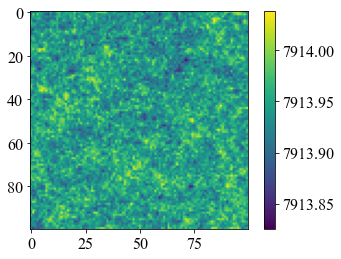

In [43]:
plt.imshow(HI[:,:,6])
plt.colorbar()

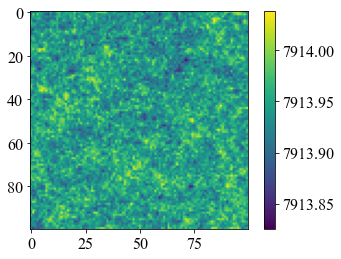

In [47]:
plt.imshow(HI[:,:,6])
plt.colorbar()

In [44]:
index = int(np.argwhere(chunck_1 == chunck_1[50]))

print(index)

50


In [45]:
HI[:,:,index]

array([[7913.95466165, 7913.95941727, 7913.94682362, ..., 7913.93941881,
        7913.97272544, 7913.95197127],
       [7913.92073276, 7913.93233305, 7913.91604016, ..., 7913.94055454,
        7913.94196212, 7913.93421704],
       [7913.94778651, 7913.96515481, 7913.89532487, ..., 7913.95819666,
        7913.95931131, 7913.96914552],
       ...,
       [7913.90616743, 7913.99619493, 7914.0041766 , ..., 7913.96102939,
        7913.93047196, 7913.95825935],
       [7913.95332096, 7913.97386225, 7913.96075424, ..., 7913.93166091,
        7913.92431046, 7913.96004134],
       [7913.95157956, 7913.94855312, 7913.95104624, ..., 7913.93779705,
        7913.93946018, 7913.99311888]])

In [64]:
universe = np.mean(HI.reshape(100,100,len(all_chuncks[0]))[:,:,1])

ValueError: cannot reshape array of size 350000 into shape (100,100,140)

In [32]:
def pixelate(img, npixes):
    n, m = img.shape
    window_n = n/npixes[0]
    n, m = n - n % window, m - m % window
    print(n % window)
    print(n % window)
    img1 = np.zeros((np.int(n/window), np.int(m/window)))
    for x in range(0, np.int(n/window)):
        for y in range(0, np.int(m/window)):
            img1[x,y] = img[window*x:(window*x)+window,y*window:(y*window)+window].mean(axis=(0,1)) 
    return img1

pixelated_universe = pixelate(universe, 5) #make new pixel 2x old pixel 

print(pixelated_universe.shape)
plt.imshow(pixelated_universe)

TypeError: 'int' object is not subscriptable

0
0
(100, 100)


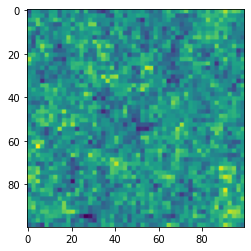

In [41]:
def pixelate(img, window):
    n, m= img.shape
    n, m = n - (n % window), m - (m % window)
    print(n % window)
    print(n % window)
    img1 = np.zeros((n, m))
    for x in range(0, n, window):
        for y in range(0, m, window):
            img1[x:x+window,y:y+window] = img[x:x+window,y:y+window].mean(axis=(0,1))
        
    return img1

pixelated_universe = pixelate(universe, 2) #make new pixel 2x old pixel 

print(pixelated_universe.shape)
plt.imshow(pixelated_universe)

In [36]:
pixelated_universe.shape

(100, 100)